In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as pdr
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# XGBoost
from xgboost import XGBClassifier
!pip install yfinance --upgrade --no-cache-dir &> /dev/null

#Polygon
!pip install polygon-api-client
from polygon import RESTClient
client = RESTClient("ySVAijwYrecApsiZErX3ETrPTr46ygXC")


In [30]:
from datetime import datetime, timedelta

# Get date range for last 8 weeks
end_date = datetime.today().date()
start_date = end_date - timedelta(weeks=8)

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

df = pd.DataFrame()

for stock in stocks:
    bars = client.get_aggs(
        ticker=stock,
        multiplier=1,       # 1-minute candles
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    )

    stock_df = pd.DataFrame(bars)
    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], unit='ms')

    # Keep only regular trading hours
    stock_df = stock_df.set_index('timestamp').between_time("09:30", "16:00").reset_index()

    # Keep only timestamp + close price
    stock_df = stock_df[['timestamp', 'close']].rename(columns={'close': stock})

    # Merge on timestamp instead of row position
    if df.empty:
        df = stock_df
    else:
        df = pd.merge(df, stock_df, on='timestamp', how='outer')

# Sort by timestamp and forward-fill small gaps
df = df.sort_values('timestamp').reset_index(drop=True)

print("Shape of DataFrame:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per stock:")
print(df.isna().sum())
print("\nLast 5 rows:")
print(df.tail())


Shape of DataFrame: (15240, 13)

Columns: ['timestamp', 'TSLA', 'NVDA', 'AAPL', 'PLTR', 'MCD', 'PEP', 'PFE', 'UBER', 'BAC', 'V', 'META', 'NFLX']

Missing values per stock:
timestamp       0
TSLA          949
NVDA          107
AAPL         3489
PLTR         1413
MCD          9015
PEP          8545
PFE          5356
UBER         6787
BAC          7792
V            8977
META         6195
NFLX         8641
dtype: int64

Last 5 rows:
                timestamp      TSLA      NVDA      AAPL      PLTR       MCD  \
15235 2025-09-19 15:56:00  423.5500  176.5100  242.8550  183.3100  302.0763   
15236 2025-09-19 15:57:00  423.7100  176.4550  243.1597  183.5500  302.0500   
15237 2025-09-19 15:58:00  424.1200  176.4522  243.3700  183.6756  302.0700   
15238 2025-09-19 15:59:00  423.8517  176.3850  243.2900  183.6300  301.9400   
15239 2025-09-19 16:00:00  424.0900  176.2950  243.2650  183.8800  301.8699   

            PEP      PFE    UBER      BAC        V      META       NFLX  
15235  140.6100  2

In [32]:
from datetime import datetime, timedelta

# Get date range for last 8 weeks
end_date = datetime.today().date()
start_date = end_date - timedelta(weeks=8)

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

df = pd.DataFrame()

for stock in stocks:
    bars = client.get_aggs(
        ticker=stock,
        multiplier=1,       # 1-minute candles
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    )

    stock_df = pd.DataFrame(bars)
    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], unit='ms')

    # Keep only regular trading hours
    stock_df = stock_df.set_index('timestamp').between_time("09:30", "16:00").reset_index()

    # Keep only timestamp + close price
    stock_df = stock_df[['timestamp', 'close']].rename(columns={'close': stock})

    # Merge on timestamp instead of row position
    if df.empty:
        df = stock_df
    else:
        df = pd.merge(df, stock_df, on='timestamp', how='outer')

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

# --- New: Check NaNs at exactly 9:30am ---
# Filter to 9:30 rows only
nine_thirty = df[df['timestamp'].dt.time == datetime.strptime("09:30", "%H:%M").time()].copy()

# Add weekday name
nine_thirty['weekday'] = nine_thirty['timestamp'].dt.day_name()

# Count NaNs per stock grouped by weekday
nan_counts = nine_thirty.groupby('weekday')[stocks].apply(lambda x: x.isna().sum())

print("NaN counts at 9:30am, grouped by weekday:")
print(nan_counts)

print("\nSample 9:30am rows:")
print(nine_thirty.head())


NaN counts at 9:30am, grouped by weekday:
           TSLA  NVDA  AAPL  PLTR  MCD  PEP  PFE  UBER  BAC  V  META  NFLX
weekday                                                                   
Friday        1     0     5     3    8    8    5     8    6  8     8     8
Monday        1     0     5     0    7    7    4     6    6  7     6     7
Thursday      2     0     4     3    8    8    6     7    7  8     6     8
Tuesday       3     0     6     3    8    8    6     6    8  8     8     8
Wednesday     2     0     5     3    8    8    7     8    7  8     7     8

Sample 9:30am rows:
               timestamp    TSLA    NVDA    AAPL    PLTR  MCD  PEP    PFE  \
0    2025-07-28 09:30:00  321.11  174.65     NaN  161.03  NaN  NaN    NaN   
391  2025-07-29 09:30:00  326.98  179.41     NaN     NaN  NaN  NaN    NaN   
782  2025-07-30 09:30:00  322.32  176.41  211.69     NaN  NaN  NaN  24.37   
1172 2025-07-31 09:30:00  318.35  182.63  209.30  159.99  NaN  NaN    NaN   
1563 2025-08-01 09:30:00  3

In [34]:
from datetime import datetime, timedelta
import pandas as pd

# Get date range for last 8 weeks
end_date = datetime.today().date()
start_date = end_date - timedelta(weeks=8)

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

df = pd.DataFrame()

for stock in stocks:
    bars = client.get_aggs(
        ticker=stock,
        multiplier=5,       # 5-minute candles
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    )

    stock_df = pd.DataFrame(bars)
    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], unit='ms')

    # Keep only regular trading hours (10:00–16:00)
    stock_df = stock_df.set_index('timestamp').between_time("10:00", "16:00").reset_index()

    # Keep OHLCV + VWAP + trade count, rename with stock suffix
    stock_df = stock_df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions']].rename(
        columns={
            'open': f'{stock}_open',
            'high': f'{stock}_high',
            'low': f'{stock}_low',
            'close': f'{stock}_close',
            'volume': f'{stock}_volume',
            'vwap': f'{stock}_vwap',
            'transactions': f'{stock}_trades'
        }
    )

    # Merge on timestamp
    if df.empty:
        df = stock_df
    else:
        df = pd.merge(df, stock_df, on='timestamp', how='outer')

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print("Shape of DataFrame:", df.shape)
print("\nColumns:", df.columns.tolist()[:15], "...")
print("\nMissing values (first 10 cols):")
print(df.isna().sum().head(10))
print("\nLast 5 rows:")
print(df.tail())


Shape of DataFrame: (2847, 85)

Columns: ['timestamp', 'TSLA_open', 'TSLA_high', 'TSLA_low', 'TSLA_close', 'TSLA_volume', 'TSLA_vwap', 'TSLA_trades', 'NVDA_open', 'NVDA_high', 'NVDA_low', 'NVDA_close', 'NVDA_volume', 'NVDA_vwap', 'NVDA_trades'] ...

Missing values (first 10 cols):
timestamp      0
TSLA_open      1
TSLA_high      1
TSLA_low       1
TSLA_close     1
TSLA_volume    1
TSLA_vwap      1
TSLA_trades    1
NVDA_open      0
NVDA_high      0
dtype: int64

Last 5 rows:
               timestamp  TSLA_open  TSLA_high  TSLA_low  TSLA_close  \
2842 2025-09-19 15:40:00   423.8400   424.9600  423.6548    424.8970   
2843 2025-09-19 15:45:00   424.9000   424.9300  424.0200    424.0900   
2844 2025-09-19 15:50:00   424.0900   424.1199  423.4900    423.8650   
2845 2025-09-19 15:55:00   423.8429   424.1500  423.1200    423.8517   
2846 2025-09-19 16:00:00   423.8538   424.9500  423.5400    424.8866   

      TSLA_volume  TSLA_vwap  TSLA_trades  NVDA_open  NVDA_high  ...  \
2842    1341859.

In [35]:
from datetime import datetime, timedelta
import pandas as pd

# Get date range for last 8 weeks
end_date = datetime.today().date()
start_date = end_date - timedelta(weeks=8)

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

df = pd.DataFrame()

for stock in stocks:
    bars = client.get_aggs(
        ticker=stock,
        multiplier=1,       # 1-minute candles so we capture 9:30 exactly
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    )

    stock_df = pd.DataFrame(bars)
    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], unit='ms')

    # Keep only 9:30 AM rows
    stock_df = stock_df.set_index('timestamp').between_time("09:30", "09:30").reset_index()

    if stock_df.empty:
        continue

    stock_df = stock_df[['timestamp', 'volume', 'vwap']].rename(
        columns={
            'volume': f'{stock}_volume',
            'vwap': f'{stock}_vwap'
        }
    )

    # Merge on timestamp
    if df.empty:
        df = stock_df
    else:
        df = pd.merge(df, stock_df, on='timestamp', how='outer')

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print("Shape of 9:30 DataFrame:", df.shape)
print("\nFirst few rows of 9:30 data:")
print(df.head())

# Diagnostic: how often VWAP is NaN and what volume looks like
for stock in stocks:
    vwap_col = f"{stock}_vwap"
    vol_col = f"{stock}_volume"
    if vwap_col in df.columns:
        missing_vwap = df[vwap_col].isna().sum()
        if missing_vwap > 0:
            print(f"\n{stock}: {missing_vwap} NaN VWAP rows at 9:30")
            print(df.loc[df[vwap_col].isna(), [vol_col, vwap_col]].head())


Shape of 9:30 DataFrame: (39, 17)

First few rows of 9:30 data:
            timestamp  TSLA_volume  TSLA_vwap  NVDA_volume  NVDA_vwap  \
0 2025-07-28 09:30:00      12369.0   321.0052       2388.0   174.6362   
1 2025-07-29 09:30:00       1080.0   326.9554      11007.0   179.3941   
2 2025-07-30 09:30:00       2319.0   322.3145        493.0   176.4056   
3 2025-07-31 09:30:00       1034.0   318.3818       2468.0   182.6458   
4 2025-08-01 09:30:00       4008.0   303.2949      29481.0   173.0166   

   AAPL_volume  AAPL_vwap  PLTR_volume  PLTR_vwap  PFE_volume  PFE_vwap  \
0          NaN        NaN       1238.0   161.0242         NaN       NaN   
1          NaN        NaN          NaN        NaN         NaN       NaN   
2        389.0   211.6836          NaN        NaN       189.0     24.37   
3        849.0   209.2979       1173.0   159.9896         NaN       NaN   
4       1684.0   211.6910       1983.0   154.1502       308.0     23.19   

   UBER_volume  UBER_vwap  BAC_volume  BAC_vwa

In [31]:
from datetime import datetime, timedelta

# Get date range for last 8 weeks
end_date = datetime.today().date()
start_date = end_date - timedelta(weeks=8)

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

df = pd.DataFrame()

for stock in stocks:
    bars = client.get_aggs(
        ticker=stock,
        multiplier=5,       # 5-minute candles
        timespan="minute",  # still "minute", multiplier changes granularity
        from_=start_date,
        to=end_date,
        limit=50000
    )

    stock_df = pd.DataFrame(bars)
    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'], unit='ms')

    # Keep only regular trading hours
    stock_df = stock_df.set_index('timestamp').between_time("09:30", "16:00").reset_index()

    # Keep only timestamp + close price
    stock_df = stock_df[['timestamp', 'close']].rename(columns={'close': stock})

    # Merge on timestamp instead of row position
    if df.empty:
        df = stock_df
    else:
        df = pd.merge(df, stock_df, on='timestamp', how='outer')

# Sort by timestamp and forward-fill small gaps
df = df.sort_values('timestamp').reset_index(drop=True)

print("Shape of DataFrame:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per stock:")
print(df.isna().sum())
print("\nLast 5 rows:")
print(df.tail())


Shape of DataFrame: (3081, 13)

Columns: ['timestamp', 'TSLA', 'NVDA', 'AAPL', 'PLTR', 'MCD', 'PEP', 'PFE', 'UBER', 'BAC', 'V', 'META', 'NFLX']

Missing values per stock:
timestamp       0
TSLA            2
NVDA            0
AAPL          156
PLTR           13
MCD          1642
PEP          1366
PFE           361
UBER          799
BAC          1003
V            1602
META          650
NFLX         1345
dtype: int64

Last 5 rows:
               timestamp      TSLA      NVDA     AAPL      PLTR      MCD  \
3076 2025-09-19 15:40:00  424.8970  176.1650  242.640  182.8400  302.925   
3077 2025-09-19 15:45:00  424.0900  176.2601  242.600  182.5799  302.650   
3078 2025-09-19 15:50:00  423.8650  176.4135  242.915  183.3389  302.190   
3079 2025-09-19 15:55:00  423.8517  176.3850  243.290  183.6300  301.940   
3080 2025-09-19 16:00:00  424.8866  176.3850  243.395  184.0050  301.850   

           PEP      PFE    UBER     BAC       V    META      NFLX  
3076  140.6700  23.8900  97.795  52.250  34

In [ ]:
import yfinance as yf
import pandas as pd

stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

# Create a single dataframe with stock symbols as columns
# We'll use the 'Close' price for each stock
df = pd.DataFrame()

for stock in stocks:
    data = yf.download(
        stock,
        period="60d",        # Yahoo limit for 5m data (~2 months)
        interval="5m"        # 5-minute candles
    )
    df[stock] = data['Close']

# Save the combined dataframe
df.to_csv("all_stocks_5m.csv")

print("Combined DataFrame shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nColumn names:")
print(df.columns.tolist())



/tmp/ipython-input-1486679630.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1486679630.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1486679630.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1486679630.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1486679630.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%*************

In [ ]:
df.shape

In [ ]:
import numpy as np

# ---------- MACD for 5m with crossover signals ----------
def calculate_macd(series, fast=19, slow=39, signal=9):
    """MACD tuned a bit slower for 5m bars to reduce noise."""
    s = pd.to_numeric(series, errors="coerce")
    ema_fast = s.ewm(span=fast, adjust=False).mean()
    ema_slow = s.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    sig  = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - sig
    return macd, sig, hist

price_cols = list(df.columns)
macd_df = pd.DataFrame(index=df.index)

for col in price_cols:
    macd, sig, hist = calculate_macd(df[col])
    macd_df[f"{col}_MACD"]   = macd
    macd_df[f"{col}_Signal"] = sig
    macd_df[f"{col}_Hist"]   = hist

    # --- crossover EVENTS (not state) ---
    cross_up   = (macd > sig) & (macd.shift(1) <= sig.shift(1))     # bullish cross
    cross_down = (macd < sig) & (macd.shift(1) >= sig.shift(1))     # bearish cross

    sig_series = pd.Series("Hold", index=df.index)
    sig_series[cross_up] = "Buy"
    sig_series[cross_down] = "Sell"

    # act on next bar to avoid look-ahead
    macd_df[f"{col}_MACD_Signal"] = sig_series.shift(1).fillna("Hold")

# optional: simple trend filter to cut whipsaws (uncomment if you want)
# for col in price_cols:
#     m = macd_df[f"{col}_MACD"]
#     filt = macd_df[f"{col}_MACD_Signal"].copy()
#     filt[(filt=="Buy")  & (m <= 0)] = "Hold"
#     filt[(filt=="Sell") & (m >= 0)] = "Hold"
#     macd_df[f"{col}_MACD_Signal"] = filt

# save & quick sanity check
macd_df.to_csv("all_stocks_5m_macd.csv")
for col in price_cols:
    print(col, macd_df[f"{col}_MACD_Signal"].value_counts().to_dict())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ensure we have a 'Date' column for plotting (works if df has DatetimeIndex)
if "Date" not in df.columns:
    df = df.reset_index().rename(columns={"Datetime": "Date", "index": "Date"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

def calculate_macd(series, fast=19, slow=39, signal=9):
    """MACD tuned a bit slower for 5m bars to reduce noise."""
    s = pd.to_numeric(series, errors="coerce")
    ema_fast = s.ewm(span=fast, adjust=False).mean()
    ema_slow = s.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    sig  = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - sig
    return macd, sig, hist

# plotting (no Buy/Sell markers)
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

for col in df.columns[1:]:  # Skip 'Date'
    macd, sig, hist = calculate_macd(df[col])

    x = pd.to_datetime(df['Date'])

    plt.figure(figsize=(12, 6))
    # MACD lines
    plt.plot(x, macd, label=f'{col} MACD', linewidth=1.2)
    plt.plot(x, sig,  label=f'{col} Signal', linewidth=1.2)
    # Histogram (split pos/neg just for readability)
    pos = hist.clip(lower=0)
    neg = hist.clip(upper=0)
    plt.bar(x, pos, alpha=0.4, label='Histogram +')
    plt.bar(x, neg, alpha=0.4, label='Histogram -')
    # zero line
    plt.axhline(0, linewidth=0.8, color='black')

    plt.title(f'{col} MACD (5m)')
    plt.xlabel('Date')
    plt.ylabel('MACD Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_bollinger_bands(df_col, window=20, num_std_dev=2):
    """Calculates Bollinger Bands for a given stock price series."""
    rolling_mean = df_col.rolling(window=window).mean()
    rolling_std = df_col.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return rolling_mean, upper_band, lower_band

# Define period and multiplier
period = 20
multiplier = 2

# Plotting the Bollinger Bands for each stock
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

for col in df.columns[1:]:  # Skip the 'Date' column
    rolling_mean, upper_band, lower_band = calculate_bollinger_bands(df[col], window=period, num_std_dev=multiplier)

    plt.figure(figsize=(12, 6))
    #plt.plot(pd.to_datetime(df['Date']), df[col], label=f'{col} Close Price', color='blue')
    plt.plot(pd.to_datetime(df['Date']), rolling_mean, label=f'{col} Rolling Mean', color='red')
    plt.plot(pd.to_datetime(df['Date']), upper_band, label=f'{col} Upper Band', color='green')
    plt.plot(pd.to_datetime(df['Date']), lower_band, label=f'{col} Lower Band', color='orange')
    plt.title(f'{col} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

print("Combined DataFrame shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

In [ ]:
def calculate_rsi(df_col, window=14):
    """Calculates the Relative Strength Index (RSI) for a given stock price series."""
    delta = df_col.diff()
    gain = delta.mask(delta < 0, 0)
    loss = delta.mask(delta > 0, 0).abs()

    avg_gain = gain.ewm(com=window - 1, adjust=False).mean()
    avg_loss = loss.ewm(com=window - 1, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate and plot RSI for each stock
for col in df.columns[1:]:  # Skip the 'Date' column
    df[f'{col}_RSI'] = calculate_rsi(df[col])

    fig = plt.figure(figsize=(14,10))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(pd.to_datetime(df['Date']), df[col])
    ax1.set_title(f'Stock {col} Closing Price')
    ax1.set_ylabel('Price')

    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(pd.to_datetime(df['Date']), df[f'{col}_RSI'], label='Relative Strengths Index')
    # Adjust text positions based on the actual date range and RSI values
    # For simplicity, I'll place text at the beginning of the plot and fixed y-values
    ax2.text(s='Overbought', x=pd.to_datetime(df['Date'].iloc[30]), y=75, fontsize=14)
    ax2.text(s='Oversold', x=pd.to_datetime(df['Date'].iloc[30]), y=25, fontsize=14)
    ax2.axhline(y=70, color='red')
    ax2.axhline(y=30, color='red')
    ax2.grid()
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    plt.show()

print("Combined DataFrame shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

simple moving average leads to lag (Bad for day traders). We need something that responds faster like exponential. Also small timeframe leads to whipsaws. Moving averages dont predict future trends they confirm them

exclusive time series analysis

When you calculate MACD, you get the difference between two EMAs (fast EMA – slow EMA).
That raw line (blue in your chart) can be choppy.

To smooth it, we calculate another EMA of the MACD itself, usually a 9-period EMA.
That’s called the Signal Line (red in your chart).

👉 Why it matters:

When MACD crosses above Signal Line → bullish (buy).

When MACD crosses below Signal Line → bearish (sell).

🔹 RSI (Relative Strength Index)

Buy (Oversold): RSI < 30

Sell (Overbought): RSI > 70

(Optional) RSI between 30–70 → HOLD (no action)

🔹 Bollinger Bands (BB)

Buy: Price closes below Lower Band (stock is unusually cheap)

Sell: Price closes above Upper Band (stock is unusually expensive)

(Optional) Price between bands → HOLD

🔹 MACD (Moving Average Convergence Divergence)

Buy: MACD line crosses above Signal line (momentum turning bullish)

Sell: MACD line crosses below Signal line (momentum turning bearish)

(Optional) If MACD histogram is near zero → HOLD

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# ----------------------------
# 1) Fetch 5-minute prices
# ----------------------------
stocks = ["TSLA", "NVDA", "AAPL", "PLTR", "MCD", "PEP", "PFE", "UBER", "BAC", "V", "META", "NFLX"]

# Build a wide price table (DatetimeIndex, columns=tickers)
df_prices = pd.DataFrame()
for s in stocks:
    d = yf.download(s, period="60d", interval="5m", auto_adjust=True, progress=False)
    df_prices[s] = d["Close"]

# Move index to a proper 'Date' column for the style you want
df = df_prices.reset_index().rename(columns={"Datetime": "Date", "index": "Date"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# ----------------------------
# 2) Indicator calculators
# ----------------------------
def calculate_macd(series, fast=19, slow=39, signal=9):
    """MACD tuned slightly slower for noisy 5m bars."""
    s = pd.to_numeric(series, errors="coerce")
    ema_fast = s.ewm(span=fast, adjust=False).mean()
    ema_slow = s.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    sig  = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - sig
    return macd, sig, hist

def macd_crossover_signal(macd, sig):
    """Event-based Buy/Sell on crossovers; shifted by 1 bar to avoid look-ahead."""
    cross_up   = (macd > sig) & (macd.shift(1) <= sig.shift(1))   # bullish cross
    cross_down = (macd < sig) & (macd.shift(1) >= sig.shift(1))   # bearish cross
    out = pd.Series("Hold", index=macd.index)
    out[cross_up] = "Buy"
    out[cross_down] = "Sell"
    return out.shift(1).fillna("Hold")

def calculate_bollinger_bands(series, window=20, num_std_dev=2.0):
    s = pd.to_numeric(series, errors="coerce")
    mid = s.rolling(window=window).mean()
    std = s.rolling(window=window).std()
    upper = mid + num_std_dev * std
    lower = mid - num_std_dev * std
    return mid, upper, lower

def calculate_rsi(series, window=14):
    s = pd.to_numeric(series, errors="coerce")
    delta = s.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Wilder-style smoothing via EWM with alpha = 1/window
    avg_gain = gain.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def get_bollinger_signal(price, upper, lower):
    # State-based (fine for BB). If you want events-only, you can add cross detection.
    out = pd.Series("Hold", index=price.index)
    out[price <= lower] = "Buy"
    out[price >= upper] = "Sell"
    return out

def get_rsi_signal(rsi, low_th=30, high_th=70):
    out = pd.Series("Hold", index=rsi.index)
    out[rsi <= low_th] = "Buy"
    out[rsi >= high_th] = "Sell"
    return out

# ----------------------------
# 3) Compute indicators & signals per ticker
# ----------------------------
price_cols = [c for c in df.columns if c != "Date"]

for col in price_cols:
    # MACD
    macd, sig, hist = calculate_macd(df[col])
    df[f"{col}_MACD"]     = macd
    df[f"{col}_Signal"]   = sig
    df[f"{col}_Histogram"] = hist
    df[f"{col}_MACD_Signal"] = macd_crossover_signal(macd, sig)

    # Bollinger
    mid, upper, lower = calculate_bollinger_bands(df[col], window=20, num_std_dev=2.0)
    df[f"{col}_Rolling_Mean"] = mid
    df[f"{col}_Upper_Band"]   = upper
    df[f"{col}_Lower_Band"]   = lower
    df[f"{col}_BB_Signal"]    = get_bollinger_signal(df[col], upper, lower)

    # RSI
    rsi = calculate_rsi(df[col], window=14)
    df[f"{col}_RSI"]        = rsi
    df[f"{col}_RSI_Signal"] = get_rsi_signal(rsi, low_th=30, high_th=70)
    # (For 5m you can consider low_th=20, high_th=80 to reduce noise)

# ----------------------------
# 4) Save & sample outputs
# ----------------------------
df.to_csv("complete_stock_analysis_5m.csv", index=False)

print("Complete DataFrame shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# Samples like your example
for ticker in ["TSLA", "AAPL"]:
    cols = [
        "Date",
        ticker,
        f"{ticker}_MACD_Signal",
        f"{ticker}_BB_Signal",
        f"{ticker}_RSI_Signal",
    ]
    print(f"\nSample of signals for {ticker}:")
    print(df[cols].tail(10))


Voting system

In [ ]:
# ----------------------------
# 5) Voting System for Final Signal
# ----------------------------

def get_voting_signal(row, stock):
    """Determines the final signal based on a majority vote of indicator signals."""
    signals = [
        row[f"{stock}_MACD_Signal"],
        row[f"{stock}_BB_Signal"],
        row[f"{stock}_RSI_Signal"]
    ]

    # Count votes for each signal
    vote_counts = pd.Series(signals).value_counts()

    # Determine the winning signal
    if len(vote_counts) == 0:
        return "Hold"
    elif vote_counts.max() == 1:
        return "Hold" # No clear majority
    else:
        # Return the signal with the highest count
        return vote_counts.idxmax()

# Apply the voting system to each row and each stock
for stock in stocks:
    df[f"{stock}_Label"] = df.apply(lambda row: get_voting_signal(row, stock), axis=1)

# Display sample of final labels
for stock in ["TSLA", "AAPL"]:
    cols = [
        "Date",
        stock,
        f"{stock}_MACD_Signal",
        f"{stock}_BB_Signal",
        f"{stock}_RSI_Signal",
        f"{stock}_Label"
    ]
    print(f"\nSample of final labels for {stock}:")
    print(df[cols].tail(10))

In [ ]:
df.columns

Index(['Date', 'TSLA', 'NVDA', 'AAPL', 'PLTR', 'MCD', 'PEP', 'PFE', 'UBER',
       'BAC',
       ...
       'MCD_Label', 'PEP_Label', 'PFE_Label', 'UBER_Label', 'BAC_Label',
       'V_Label', 'META_Label', 'NFLX_Label', 'TSLA_Next_Return',
       'TSLA_Target'],
      dtype='object', length=147)

works uptil here

<Axes: title={'center': 'AAPL Label Distribution'}>

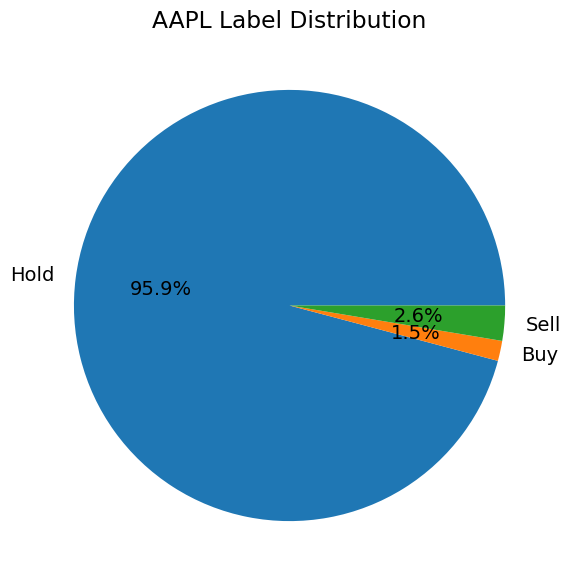

In [ ]:
counts = df["AAPL_Label"].value_counts(normalize=True).reindex(["Hold","Buy","Sell"]).fillna(0)
counts.plot.pie(autopct="%1.1f%%", ylabel="", title="AAPL Label Distribution")


**XGBoost**

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
)

# --- Make sure we have a Date column as datetime ---
if "Date" not in df.columns:
    df = df.reset_index().rename(columns={"Datetime": "Date", "index": "Date"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# --- Config ---
stocks = ["TSLA","NVDA","AAPL","PLTR","MCD","PEP","PFE","UBER","BAC","V","META","NFLX"]
label_map = {"Sell": 0, "Hold": 1, "Buy": 2}
inv_label_map = {v: k for k, v in label_map.items()}
n_splits = 5  # CV folds on the train/val partition

# Feature set per stock (adjust if you want to add/remove features)
def features_for(stock):
    return [
        f"{stock}_MACD",
        f"{stock}_Signal",
        f"{stock}_Histogram",
        f"{stock}_RSI",
        f"{stock}_Upper_Band",
        f"{stock}_Lower_Band",
        f"{stock}_Rolling_Mean",

    ]

# --- Helpers ---
def class_weights(y_train_int):
    """Inverse-frequency weights for classes present in y_train."""
    uniq, cnt = np.unique(y_train_int, return_counts=True)
    k = len(uniq)
    n = len(y_train_int)
    w = {cls: n / (k * c) for cls, c in zip(uniq, cnt)}
    return np.array([w[c] for c in y_train_int], dtype=float)

def soft_vote_summary(proba_avg):
    return {
        "label": inv_label_map[int(np.argmax(proba_avg))],
        "probs": {"Sell": float(proba_avg[0]),
                  "Hold": float(proba_avg[1]),
                  "Buy":  float(proba_avg[2])}
    }

# --- Main loop per stock ---
weekly_majority = {}
weekly_softvote = {}
latest_predictions = {}

for stock in stocks:
    label_col = f"{stock}_Label"
    feat_cols = features_for(stock)
    missing = [c for c in [label_col, *feat_cols, "Date"] if c not in df.columns]
    if missing:
        print(f"\n[{stock}] Skipping — missing columns: {missing}")
        continue

    # Build dataset and drop NaNs from rolling indicators
    data = df[["Date"] + feat_cols + [label_col]].dropna().copy()
    if len(data) < 400:
        print(f"\n[{stock}] Skipping — too few usable rows after dropna: {len(data)}")
        continue

    # Target
    y_all = data[label_col].map(label_map).astype(int).values
    X_all = data[feat_cols].values
    dates_all = data["Date"].values

    # Hold out the last week as TEST
    last_dt = data["Date"].max()
    week_start = last_dt - pd.Timedelta(days=7)
    test_mask = data["Date"] >= week_start
    trainval_mask = ~test_mask

    if test_mask.sum() < 20 or trainval_mask.sum() < 200:
        print(f"\n[{stock}] Skipping — trainval={trainval_mask.sum()}, test={test_mask.sum()}")
        continue

    X_tv, y_tv, d_tv = X_all[trainval_mask], y_all[trainval_mask], dates_all[trainval_mask]
    X_te, y_te, d_te = X_all[test_mask], y_all[test_mask], dates_all[test_mask]

    # ---- TimeSeriesSplit CV on train/val (expanding window) ----
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_metrics = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_tv), 1):
        X_tr, y_tr = X_tv[tr_idx], y_tv[tr_idx]
        X_va, y_va = X_tv[va_idx], y_tv[va_idx]


        sw = class_weights(y_tr)

        model = XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            n_estimators=400,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="mlogloss",
            random_state=42,
            tree_method="hist",
        )
        model.fit(X_tr, y_tr, sample_weight=sw, eval_set=[(X_va, y_va)], verbose=False)

        y_hat = model.predict(X_va)
        fold_metrics.append({
            "fold": fold,
            "n_val": len(y_va),
            "acc": accuracy_score(y_va, y_hat),
            "bal_acc": balanced_accuracy_score(y_va, y_hat),
            "f1_macro": f1_score(y_va, y_hat, average="macro", zero_division=0),
            "f1_weighted": f1_score(y_va, y_hat, average="weighted", zero_division=0),
        })

    # Print CV summary
    cv_df = pd.DataFrame(fold_metrics)
    print(f"\n[{stock}] CV ({n_splits} folds on Train/Val)")
    print(cv_df)
    print("CV means:", cv_df.drop(columns=["fold","n_val"]).mean().to_dict())

    # ---- Train final model on ALL Train/Val ----
    sw_final = class_weights(y_tv)
    final_model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42,
        tree_method="hist",
    )
    final_model.fit(X_tv, y_tv, sample_weight=sw_final, eval_set=[(X_tv[-len(X_te):], y_tv[-len(X_te):])], verbose=False)

    # ---- Evaluate on last-week TEST ----
    y_pred = final_model.predict(X_te)
    proba  = final_model.predict_proba(X_te)  # shape [T,3]
    acc = accuracy_score(y_te, y_pred)
    bal = balanced_accuracy_score(y_te, y_pred)
    print(f"\n[{stock}] TEST (last week): {pd.to_datetime(d_te.min())} → {pd.to_datetime(d_te.max())}  "
          f"(rows={len(y_te)})")
    print(f"Accuracy={acc:.4f}  |  BalancedAcc={bal:.4f}")
    print(classification_report(y_te, y_pred, target_names=["Sell","Hold","Buy"], zero_division=0))

    # Majority (hard) vote over the week
    majority_code = int(pd.Series(y_pred).value_counts().idxmax())
    weekly_majority[stock] = inv_label_map[majority_code]

    # Soft vote (avg probabilities) over the week
    avg_proba = proba.mean(axis=0)
    weekly_softvote[stock] = soft_vote_summary(avg_proba)

    # Last bar prediction from full df (latest available features row)
    latest_feats = data[feat_cols].iloc[[-1]].values
    last_code = int(final_model.predict(latest_feats)[0])
    latest_predictions[stock] = inv_label_map[last_code]

    # Save model
    # (keep both model and feat list if you want to predict later on new bars)
    if 'stock_models' not in globals():
        stock_models = {}
    stock_models[stock] = (final_model, feat_cols)

# ---- Summaries ----
print("\n=== Weekly Recommendation (majority vote on last week) ===")
for s, lbl in weekly_majority.items():
    print(f"{s}: {lbl}")

print("\n=== Weekly Recommendation (soft vote: avg probabilities over last week) ===")
for s, info in weekly_softvote.items():
    print(f"{s}: {info['label']}  |  P(Sell)={info['probs']['Sell']:.2f}  "
          f"P(Hold)={info['probs']['Hold']:.2f}  P(Buy)={info['probs']['Buy']:.2f}")

print("\n=== Latest Bar Prediction (most recent row) ===")
for s, lbl in latest_predictions.items():
    print(f"{s}: {lbl}")



[TSLA] CV (5 folds on Train/Val)
   fold  n_val       acc   bal_acc  f1_macro  f1_weighted
0     1    705  0.980142  0.871118  0.859344     0.980711
1     2    705  0.947518  0.750462  0.677084     0.949670
2     3    705  0.977305  0.684816  0.768777     0.974263
3     4    705  0.954610  0.747991  0.736827     0.952940
4     5    705  0.939007  0.864478  0.730712     0.943216
CV means: {'acc': 0.9597163120567375, 'bal_acc': 0.7837730843597047, 'f1_macro': 0.7545484926862357, 'f1_weighted': 0.960160083743248}

[TSLA] TEST (last week): 2025-09-12 19:55:00 → 2025-09-19 19:55:00  (rows=391)
Accuracy=0.9974  |  BalancedAcc=0.9991
              precision    recall  f1-score   support

        Sell       1.00      1.00      1.00         6
        Hold       1.00      1.00      1.00       373
         Buy       0.92      1.00      0.96        12

    accuracy                           1.00       391
   macro avg       0.97      1.00      0.99       391
weighted avg       1.00      1.00     